# 🎮 Steam Review Scraper

Hecho por [Alejandro Barrionuevo Rosado](https://github.com/Alejandro-BR) y [Alvaro López Guerrero](https://github.com/Alvalogue72).

Repositorio: **[GitHub](https://github.com/Alejandro-BR/Steam-Review-Scraper)**




## Imagen general

Recopila datos textuales de los comentarios de Steam y analiza las emociones presentes en el contenido, mostrando estadísticas y visualizaciones intuitivas.

## Importaciones

In [26]:
import json
import re
import time
from datetime import datetime
from html import unescape

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

## **Obtención de los datos**

Para llevar a cabo el proyecto, hicimos una búsqueda de los datos de las dos formas posibles que ofrece **Steam**, mediante **web scraping** y usando su **API**, aunque con la API es mucho más eficiente y rápido.

Aunque para trabajar con los datos solo utilizaremos la **API**, ya que el **web scraping** es mucho más costoso y tarda cantidades de tiempo muy elevadas y en cambio, con la **API** podemos obtener más datos en mucho menos tiempo.

Utilizaremos como ejemplo el juego: [Call of Duty®: Black Ops 7](https://store.steampowered.com/app/3606480/Call_of_Duty_Black_Ops_7/)

In [27]:
ID = 3606480  # Call of Duty®: Black Ops 7

### **API de Steam**

Hemos limitado el conjunto de datos a **10.000 reseñas** para evitar tiempos de carga de varias horas al descargar los comentarios.

Documentación: [API OFICIAL](https://partner.steamgames.com/doc/store/getreviews?l=spanish&language=english)

```python
url = f"https://store.steampowered.com/appreviews/{id}"
```





Logs personalizados para mostrar lo que va ocurriendo durante la obtención de los datos.

In [28]:
def log(message, level="INFO"):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] [{level}] {message}")

Elimina cualquier etiqueta `HTML` presente en el texto.

In [29]:
def clean_html(text):
    text = unescape(text)
    text = re.sub(r"<.*?>", "", text)
    return text.strip()

Realiza un `GET` a la API de Steam usando los parámetros necesarios.

In [30]:
def fetch_reviews(id, cursor="*"):
    url = f"https://store.steampowered.com/appreviews/{id}"
    params = {
        "json": 1,
        "language": "spanish",
        "filter": "all",
        "review_type": "all",
        "purchase_type": "all",
        "num_per_page": 100,
        "cursor": cursor
    }
    try:
        r = requests.get(url, params=params, timeout=20)
        return r.json()
    except Exception as e:
        log(f"Error interpretando JSON: {e}", level="ERROR")
        return None

Construye nuestro `DataFrame`.

In [31]:
def scrape_to_dataframe(id, max = 10000):
    cursor = "*"
    total = 0
    data_list = []

    while True:
        log(f"Solicitando cursor: {cursor}")
        data = fetch_reviews(id, cursor)
        if not data or "success" not in data or data["success"] != 1:
            log("Error o respuesta inválida", level="ERROR")
            break

        reviews = data.get("reviews", [])
        if not reviews:
            log("No hay más reseñas. Fin.", level="DONE")
            break

        for r in reviews:
            item = {
                "recommended": r.get("voted_up"),
                "hours": r.get("author", {}).get("playtime_forever", 0) / 60,
                "timestamp_created": r.get("timestamp_created"),
                "timestamp_updated": r.get("timestamp_updated"),
                "review": clean_html(r.get("review", "")),
            }
            data_list.append(item)
            total += 1

            if total >= max:
                log(f"Límite de {max} reseñas alcanzado. Fin.", level="DONE")
                df = pd.DataFrame(data_list)
                return df

        log(f"Descargadas hasta ahora: {total}")
        cursor = data.get("cursor")
        if not cursor:
            log("Cursor vacío -> fin", level="DONE")
            break

        time.sleep(1.2)

    df = pd.DataFrame(data_list)
    log(f"FIN — Total reseñas en DataFrame: {len(df)}", level="DONE")
    return df

Obtenemos el dataframe con 10.000 reseñas.

In [32]:
MAX_REVIEWS = 10000
reviews_df = scrape_to_dataframe(ID, MAX_REVIEWS)

[2025-11-28 19:57:01] [INFO] Solicitando cursor: *
[2025-11-28 19:57:02] [INFO] Descargadas hasta ahora: 37
[2025-11-28 19:57:03] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-28 19:57:03] [INFO] Descargadas hasta ahora: 74
[2025-11-28 19:57:04] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-28 19:57:04] [INFO] Descargadas hasta ahora: 111
[2025-11-28 19:57:06] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-28 19:57:06] [INFO] Descargadas hasta ahora: 148
[2025-11-28 19:57:07] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-28 19:57:08] [INFO] Descargadas hasta ahora: 185
[2025-11-28 19:57:09] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-28 19:57:09] [INFO] Descargadas hasta ahora: 222
[2025-11-28 19:57:10] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-28 19:57:11] [INFO] Descargadas hasta ahora: 259
[2025-11-28 19:57:12] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-28 19:57:12] [INFO

Podemos observar que disponemos de si el usuario recomienda o no el juego, las horas que jugó, las fechas y lo que nos interesa la `review`.

In [33]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommended        10000 non-null  bool   
 1   hours              10000 non-null  float64
 2   timestamp_created  10000 non-null  int64  
 3   timestamp_updated  10000 non-null  int64  
 4   review             10000 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 322.4+ KB


In [34]:
reviews_df

,recommended,hours,timestamp_created,timestamp_updated,review
0,False,0.0,1763215663,1763456058,(Actuais todos como si comprara todos los cods...
1,False,0.0,1763263727,1763263727,"TREMENDO BODRIO, CALL OF DUTY BLACK OPS 6, NI ..."
2,False,0.0,1763400014,1763400014,Menudo mojón... Lo he comprado hace 1h y ya me...
3,False,0.0,1763266112,1763266112,"los zombies mi pasión, las mujeres negras mi p..."
4,False,0.0,1763509238,1763509238,"He de reconocer que lo han logrado, han lograd..."
...,...,...,...,...,...
9995,False,0.0,1763722588,1763722588,Lo volvi a jugar por que habian quitado partid...
9996,False,0.0,1763784528,1763784528,Tiene SBMM cuando dijeron que lo habian quitad...
9997,False,0.0,1763115644,1763115644,antes el 6 iba de puta madre pero han metido u...
9998,False,0.0,1763617853,1763617853,juego de mierda en medio de la ronda 31 de zom...


### Web scraping de Steam

Hemos limitado el conjunto de datos a **100 reseñas** para evitar tiempos de carga de varias horas al descargar los comentarios.

Este apartado es solo de prueba y no se utilizará en el resto del proyecto, ya que es menos eficiente.

In [35]:
session = requests.Session()

session.cookies.set("birthtime", "0")
session.cookies.set("lastagecheckage", "1-0-1900")
session.cookies.set("wants_mature_content", "1")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "es-ES,es;q=0.9"
}

reviews_list = []
page = 1
MAX_REVIEWS_SCRAPING = 100

while True:
    print(f"[INFO] Scrapeando página {page}...")

    url = (
        f"https://steamcommunity.com/app/1172380/reviews/"
        f"?p={page}&browsefilter=toprated&filterLanguage=spanish&l=spanish"
    )

    response = session.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    reviews_html = soup.find_all("div", class_="apphub_CardTextContent")

    if not reviews_html:
        print("[DONE] No hay más comentarios en esta página. Fin.")
        break

    for r in reviews_html:
        text = r.get_text(strip=True)
        if text:
            reviews_list.append(text)
            if len(reviews_list) >= MAX_REVIEWS_SCRAPING:
                print(f"[DONE] Límite de {MAX_REVIEWS_SCRAPING} comentarios alcanzado. Fin.")
                break

    if len(reviews_list) >= MAX_REVIEWS_SCRAPING:
        break

    page += 1
    time.sleep(1)

scraping_df = pd.DataFrame(reviews_list, columns=["review"])
print(f"\n[INFO] Total comentarios extraídos: {len(scraping_df)}")


[INFO] Scrapeando página 1...
[INFO] Scrapeando página 2...
[INFO] Scrapeando página 3...
[INFO] Scrapeando página 4...
[INFO] Scrapeando página 5...
[INFO] Scrapeando página 6...
[INFO] Scrapeando página 7...
[INFO] Scrapeando página 8...
[INFO] Scrapeando página 9...
[INFO] Scrapeando página 10...
[DONE] Límite de 100 comentarios alcanzado. Fin.

[INFO] Total comentarios extraídos: 100


Ya tenemos los datos guardados en el dataframe, pero podemos observar que no vienen completamente limpios.

In [36]:
scraping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


In [37]:
scraping_df

,review
0,Publicada el 17 de marzo de 2023=== Modos de J...
1,Publicada el 26 de noviembre de 2022Larga vida...
2,Publicada el 1 de febrero de 2021compre la wea...
3,Publicada el 2 de febrero de 20212 lukita y me...
4,Publicada el 19 de noviembre de 20199 horas y ...
...,...
95,Publicada el 5 de diciembre de 2022melhor jogo...
96,Publicada el 26 de junio de 2020Edito para aña...
97,Publicada el 26 de noviembre de 2019Bueno buen...
98,Publicada el 27 de noviembre de 2020https://st...


Limpiamos los comentarios eliminando la fecha de publicación inicial.

In [43]:
clean_sc_text = lambda x: re.sub(r"^Publicada el \d{1,2} de [\w]+ de \d{4}", "", x).strip()
scraping_df["review"] = scraping_df["review"].apply(clean_sc_text)

In [44]:
print(scraping_df.head())

                                              review
0  === Modos de Juego ===✔️Un jugador❌Cooperativo...
1                      Larga vida a los singleplayer
2              compre la wea a 5 dolares, gracias ea
3                   2 lukita y media buenardo jejeje
4  9 horas y sumando, puzzles que te hacen pensar...


Aquí ya disponemos de los datos para utilizarlos, aunque como mencioné anteriormente, estos son solo de prueba y utilizaremos los otros.

In [45]:
scraping_df

,review
0,=== Modos de Juego ===✔️Un jugador❌Cooperativo...
1,Larga vida a los singleplayer
2,"compre la wea a 5 dolares, gracias ea"
3,2 lukita y media buenardo jejeje
4,"9 horas y sumando, puzzles que te hacen pensar..."
...,...
95,"melhor jogo do espadinhas, melhor que pele"
96,Edito para añadir una de las cosas mas importa...
97,"Bueno bueno, juego terminado al 85% en poco má..."
98,https://steamcommunity.com/sharedfiles/filedet...


## **Exploración y visualización de los datos**

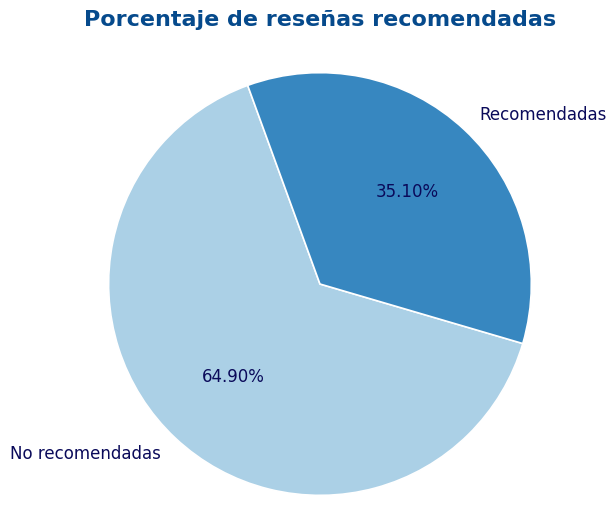

In [49]:
recommended_count = reviews_df['recommended'].sum()
not_recommended_count = len(reviews_df) - recommended_count

labels = ["No recomendadas", "Recomendadas"]
sizes = [not_recommended_count, recommended_count]

sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=2)

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    sizes,
    labels=labels,
    autopct="%1.2f%%",
    startangle=110,
    colors=colors,
    textprops={"color": "#0A0A5A", "fontsize": 12},
    wedgeprops={"linewidth": 1.2, "edgecolor": "white"}
)

ax.set_title(
    "Porcentaje de reseñas recomendadas",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

ax.axis("equal")

plt.show()
